In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from import_and_align_datasets import import_all_population_data

df_full, df_full_interp = import_all_population_data()
df_full.to_csv('historical_age_data_combined.csv', index=False)
df_full_interp.to_csv('historical_age_data_combined_interpedAges.csv', index=False)

/Users/mcmenamin/GitHub/sundries/age_distro/import_and_align_datasets.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _df['Year'] = year


In [3]:
DATE_RANGE = range(1900, 2061)

def pivot_to_heatmap(df_tallform):
    """Pivot the tall-form population data to a
    heatmap-compatible wide form
    """
    
    df_pivot = pd.pivot_table(
        df_tallform,
        values='Population',
        index='Age',
        columns='Year',
        aggfunc='mean',
        fill_value=0.0
    )
    
    # Fill in missing years and interpolate along over time
    yr_index = pd.Index(DATE_RANGE, name='Year')
    df_pivot = df_pivot.T.reindex(yr_index).interpolate('piecewise_polynomial').T
    
    # Turn into percentages
    df_pivot = 100.0 * df_pivot / df_pivot.sum(axis=0)
    
    df_pivot = df_pivot.sort_index(ascending=False)
    return df_pivot

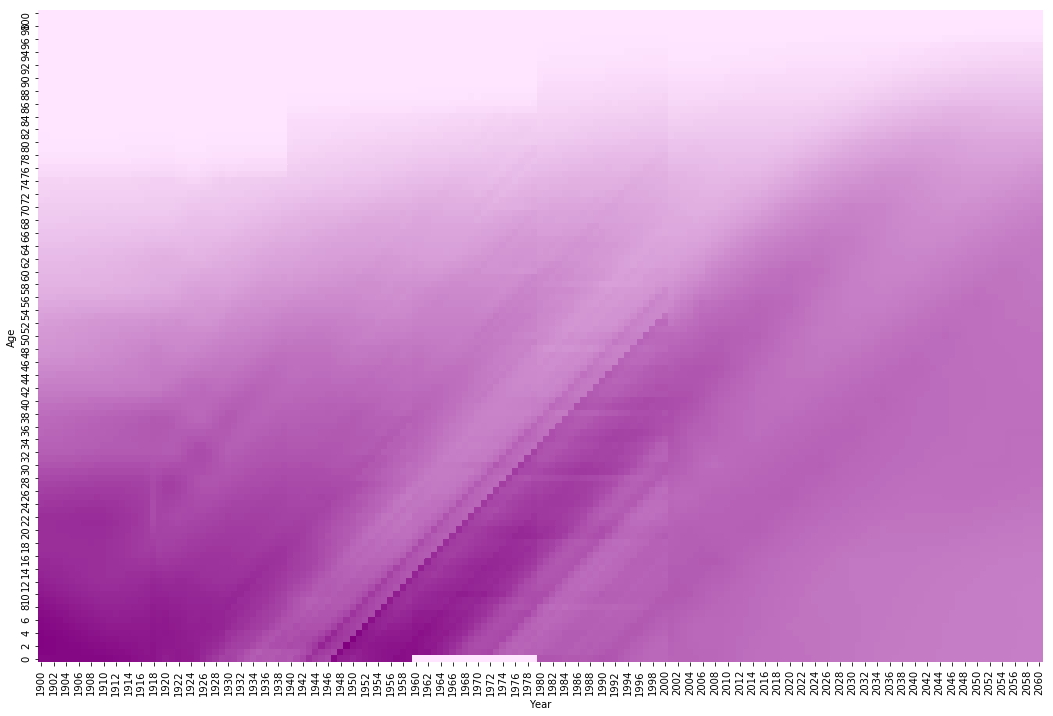

In [6]:
df_pivot_heatmap = pivot_to_heatmap(df_full)
df_pivot_interp_heatmap = pivot_to_heatmap(df_full_interp)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

sb.heatmap(
    df_pivot_interp_heatmap,
    vmin=0.0, vmax=2.5,
    cmap=sb.light_palette("Purple", n_colors=128), cbar=False,
    ax=ax
)

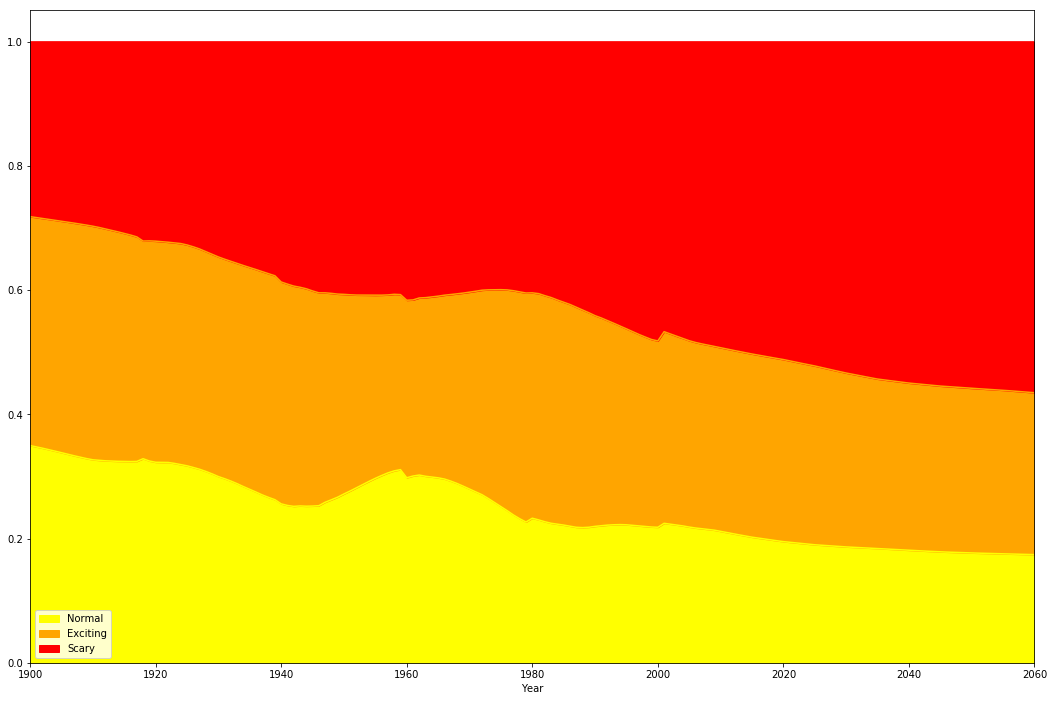

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))


_df = df_pivot_interp_heatmap.sort_index()

df_now_sentiment = pd.concat([
    _df.loc[:15].sum(axis=0).rename('Normal'),
    _df.loc[15:36].sum(axis=0).rename('Exciting'),
    _df.loc[35:].sum(axis=0).rename('Scary')
], axis=1)

df_now_sentiment = df_now_sentiment.divide(df_now_sentiment.sum(axis=1), axis=0)

df_now_sentiment.plot(stacked=True, kind='area', color=['yellow', 'orange', 'r'], ax=ax)

In [21]:
joint_df_list = []
for year_x in _df:
    for year_diff in range(0, 101):
        age_now_15_then = 15 + year_diff
        age_now_35_then = 35 + year_diff
        
        sum_norm = _df[year_x].loc[year_diff:age_now_15_then].sum()
        sum_excite = _df[year_x].loc[age_now_15_then:age_now_35_then].sum()
        sum_scary = _df[year_x].loc[age_now_35_then:].sum()
        sum_all = sum_norm + sum_excite + sum_scary

        new_dict = {
            'year': year_x,
            'year_obs': year_x - year_diff,
            'normal': sum_norm,
            'exciting': sum_excite,
            'scary': sum_scary
        }
        joint_df_list.append(new_dict)
df_joint = pd.DataFrame(joint_df_list)

df_joint['most_common'] = (
    df_joint[['normal', 'exciting', 'scary']].
    apply(np.argmax, axis=1)
)

labeldict = {
    'normal': 1,
    'exciting': 2,
    'scary': 3
}

df_joint['most_common_int'] = df_joint['most_common'].apply(lambda x: labeldict[x])

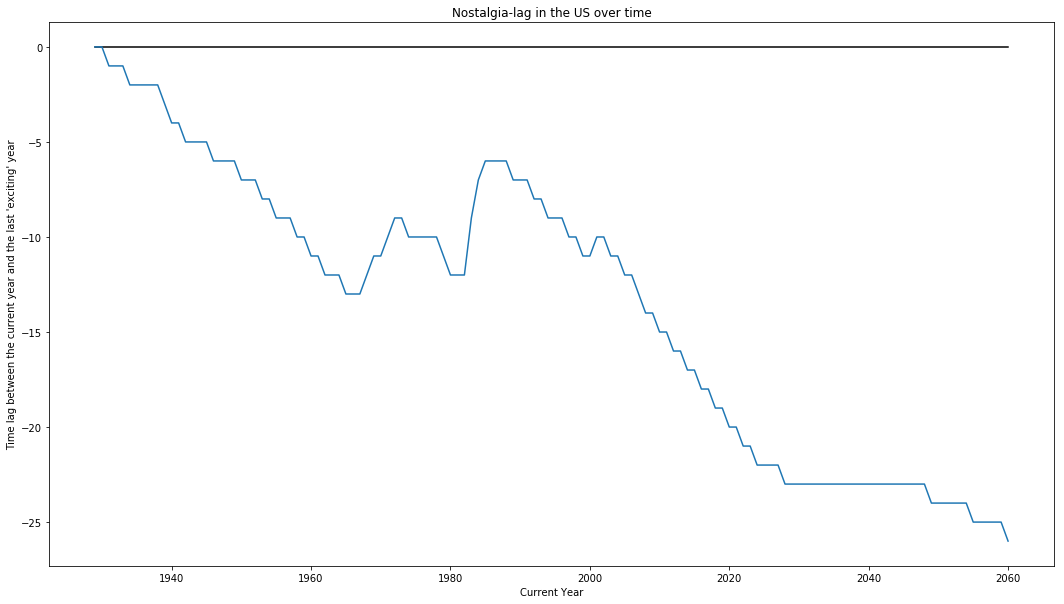

In [30]:
scary_era = (
    df_joint.loc[df_joint['most_common'] == 'scary', ['year', 'year_obs']].
    groupby('year').min()
)

time = scary_era.index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
ax.plot([time.min(), time.max()], [0, 0], '-k')
ax.plot(time, scary_era['year_obs'] - time)
ax.set_title("Nostalgia-lag in the US over time")
ax.set_xlabel("Current Year")
ax.set_ylabel("Time lag between the current year and the last 'exciting' year")

In [34]:
normal_toplot = pd.pivot_table(
    df_joint, index='year_obs', columns='year', values='normal'
)
normal_toplot = (
    normal_toplot.reindex(normal_toplot.columns).
    sort_index(ascending=False).fillna(0)
)

exciting_toplot = pd.pivot_table(
    df_joint, index='year_obs', columns='year', values='exciting'
)
exciting_toplot = (
    exciting_toplot.reindex(exciting_toplot.columns).
    sort_index(ascending=False).fillna(0)
)

scary_toplot = pd.pivot_table(
    df_joint, index='year_obs', columns='year', values='scary'
)
scary_toplot = (
    scary_toplot.reindex(scary_toplot.columns).
    sort_index(ascending=False)
)

max_toplot = pd.pivot_table(
    df_joint, index='year_obs', columns='year', values='most_common_int'
)
max_toplot = (
    max_toplot.reindex(max_toplot.columns).
    sort_index(ascending=False).fillna(-1)
)


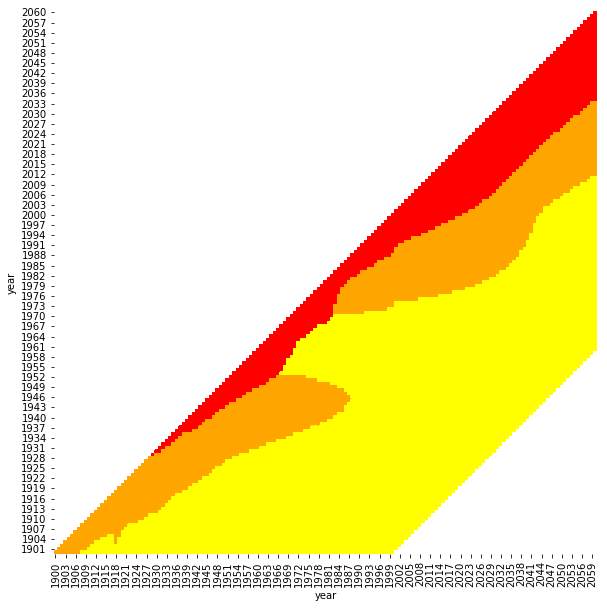

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sb.heatmap(
    max_toplot,
    vmin=0, vmax=3,
    cbar=False,
    cmap=['white', 'yellow', 'orange', 'red'], #sb.color_palette("colorblind", 5),
    square=True,
    ax=ax
)